In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from laser_jitter.data import TimeSeries

In [69]:
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

data = pd.read_csv("/home/wi73yus/focus_deviation/data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])

ts = TimeSeries(ts_data[:1000], smooth_params=smooth_params, train_size=0.8)
results = ts.smooth_split_and_scale()

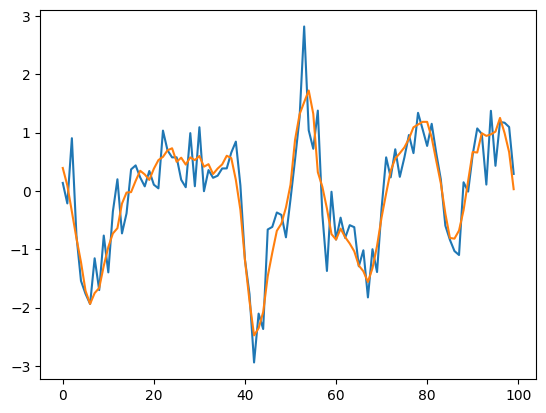

In [70]:
idx = 100
plt.figure()
plt.plot(ts.test[:idx])
plt.plot(ts.test_smooth[:idx])
plt.show()

In [74]:
a = np.arange(10).reshape((2,5))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [80]:
import torch
from torch.nn import MSELoss

a = torch.Tensor(a.flatten())
loss = MSELoss()
l = loss(a, torch.zeros_like(a))
l

tensor(28.5000)